# Preparation

In [1]:
%cd 'drive/My Drive/wheat_growth'

/content/drive/My Drive/wheat_growth


In [2]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai
!pip install -q efficientnet-pytorch

In [51]:
import random
import os
import gc
import datetime
import random
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage
from fastai.vision.all import *
from efficientnet_pytorch import EfficientNet

In [4]:
random.seed(12)
np.random.seed(12)
set_seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [5]:
main_df = pd.read_csv('Train.csv')
sub_df = pd.read_csv('SampleSubmission.csv')
main_df.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


In [6]:
hq_data = main_df[main_df['label_quality'] == 2]
hq_data.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
7,sYLqmiXV,3,2
10,rDP2EuQN,7,2
17,dMTbnE8V,2,2
21,HQWkZRNB,2,2


In [7]:
lq_data = main_df[main_df['label_quality'] == 1]
lq_data.head()

,UID,growth_stage,label_quality
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1
5,A60rOyP9,1,1


In [8]:
hq_data.growth_stage.unique(), lq_data.growth_stage.unique()

(array([4, 3, 7, 2, 5]), array([1, 6, 7, 4, 2, 5]))

In [28]:
tfms_res50 = setup_aug_tfms([Rotate(max_deg=15, p=1.),
                            RandomResizedCrop(p=1., size=256),
                            Brightness(max_lighting=1.0, p=0.4),
                            CropPad(size=256),
                            Zoom(max_zoom=1.0, p=0.2),
                            Warp(magnitude=0.2, p=0.2),
                            ])

# Image Augmentation used for Densenet201 and  lr_max = slice (10e-7, 10e-6) with 40 epochs
tfms_dn201 = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                            CropPad(size=256),
                            Zoom(max_zoom=1.5, p=0.5),
                            Warp(magnitude=0.5, p=0.5),
                            ])

# Image Augmentation used for Vgg16_bn and lr_max = slice (10e-6) with 40 epochs
tfms_vgg16 = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                    CropPad(size=256),
                    Zoom(max_zoom=1.1, p=0.5),
                    Warp(magnitude=0.2, p=0.5),
                    ])

tfms_en = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                            CropPad(size=256),
                            Zoom(max_zoom=1.1, p=0.5),
                            Warp(magnitude=0.2, p=0.2),
                            ])


In [10]:
loss_func = LabelSmoothingCrossEntropy()

# VGG16

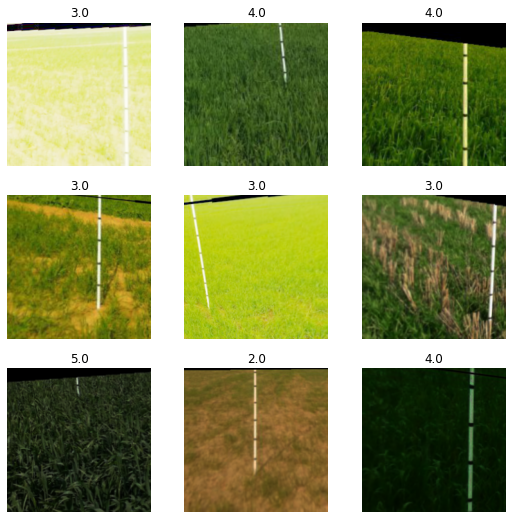

In [29]:
dls_vgg = ImageDataLoaders.from_df(hq_data,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_vgg16,
                               )

dls_vgg.show_batch()

In [32]:
learn_vgg = cnn_learner(dls_vgg, vgg16_bn, metrics=rmse, pretrained=True).to_fp16()
learn_vgg.fine_tune(70)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


epoch,train_loss,valid_loss,_rmse,time
0,18.155098,13.720836,3.704165,00:26


epoch,train_loss,valid_loss,_rmse,time
0,12.551869,10.971858,3.312379,00:26
1,11.693888,9.720675,3.117800,00:23
2,10.791520,8.041665,2.835783,00:23
3,9.674752,6.649056,2.578577,00:24
4,8.641994,5.479927,2.340924,00:24
5,7.472570,4.188012,2.046464,00:24
6,6.319327,3.117998,1.765785,00:24
7,5.272666,1.694319,1.301660,00:24
8,4.507776,1.974613,1.405209,00:24
9,3.910772,1.325168,1.151160,00:24


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.0964781722577754e-06)

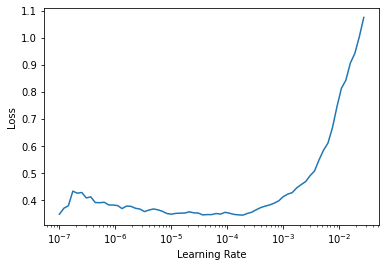

In [34]:
learn_vgg.unfreeze()
learn_vgg.lr_find()

In [35]:
learn_vgg.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.362476,0.243496,0.493454,00:23
1,0.363607,0.248303,0.498300,00:23
2,0.360418,0.241343,0.491266,00:23
3,0.353224,0.241931,0.491865,00:23
4,0.356800,0.242822,0.492769,00:23
5,0.351023,0.244176,0.494141,00:24
6,0.337442,0.257213,0.507162,00:24
7,0.342038,0.253624,0.503610,00:24
8,0.348771,0.260848,0.510733,00:23
9,0.344015,0.242388,0.492329,00:24


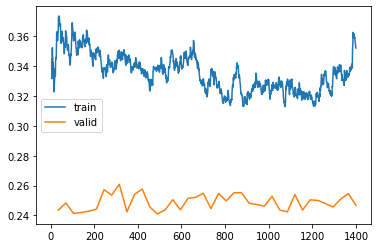

In [36]:
learn_vgg.recorder.plot_loss()

In [37]:
ss_vgg = sub_df
tdl_vgg = learn_vgg.dls.test_dl(ss_vgg)
pred_vgg = learn_vgg.tta(dl=tdl_vgg)

In [38]:
ss_vgg['growth_stage'] = pred_vgg[0].numpy()
ss_vgg.head()

,UID,growth_stage
0,F3LbWkZq,4.399414
1,6P4wLVzI,3.704834
2,Tn6HIrdS,2.787598
3,EYM5R1TK,4.101562
4,fkcevlA0,5.374268


In [39]:
now = datetime.now()
file_name = 'models/VGG16_' + now.strftime('%d_%H%M') + '.pkl'
learn_vgg.export(file_name)

In [40]:
now = datetime.now()
file_name = 'sub/VGG16_' + now.strftime('%d_%H%M') + '.csv'
ss_res50.to_csv(file_name, index=False)

# ResNet50

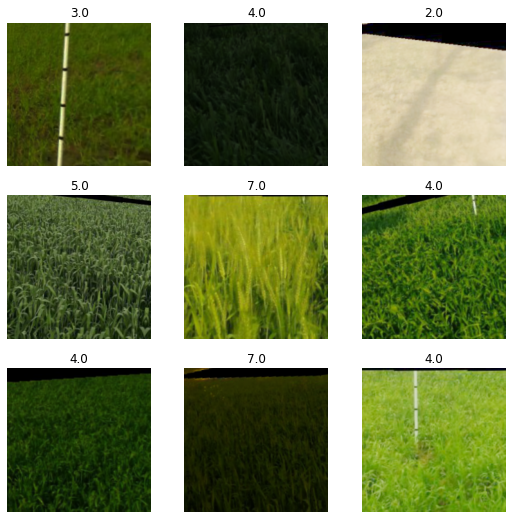

In [11]:
dls_res50 = ImageDataLoaders.from_df(hq_data,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_res50,
                               )

dls_res50.show_batch()

In [12]:
learn_res50 = cnn_learner(dls_res50, resnet50, metrics=rmse, pretrained=True).to_fp16()
learn_res50.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,18.436365,10.339782,3.215553,14:17


epoch,train_loss,valid_loss,_rmse,time
0,13.215321,10.168015,3.188732,00:17
1,12.039873,8.201443,2.863816,00:16
2,11.023014,6.502164,2.549934,00:16
3,9.983872,7.175660,2.678742,00:16
4,8.842296,4.188920,2.046685,00:17
5,7.668840,4.014172,2.003540,00:16
6,6.514444,2.996644,1.731081,00:16
7,5.414060,2.036312,1.426994,00:17
8,4.527023,0.922030,0.960224,00:16
9,3.954583,1.134348,1.065058,00:17


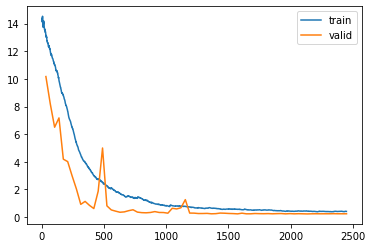

In [13]:
learn_res50.recorder.plot_loss()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

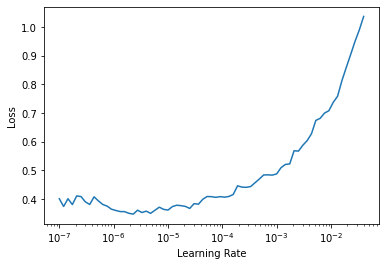

In [14]:
learn_res50.unfreeze()
learn_res50.lr_find()

In [15]:
learn_res50.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.403067,0.239442,0.489328,00:17
1,0.382537,0.240514,0.490422,00:16
2,0.395985,0.238796,0.488667,00:16
3,0.382333,0.237906,0.487756,00:16
4,0.397243,0.236906,0.486730,00:16
5,0.405446,0.243135,0.493088,00:17
6,0.409187,0.238394,0.488256,00:16
7,0.391202,0.244481,0.494451,00:16
8,0.406059,0.239324,0.489207,00:16
9,0.420607,0.240908,0.490824,00:16


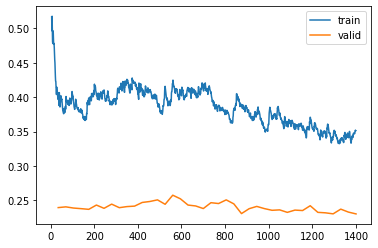

In [18]:
learn_res50.recorder.plot_loss()

In [24]:
ss_res50 = sub_df
tdl_res50 = learn_res50.dls.test_dl(ss_res50)
pred_res50 = learn_res50.tta(dl=tdl_res50)

In [25]:
ss_res50['growth_stage'] = pred_res50[0].numpy()
ss_res50.head()

,UID,growth_stage
0,F3LbWkZq,3.634033
1,6P4wLVzI,3.769653
2,Tn6HIrdS,2.687012
3,EYM5R1TK,4.096313
4,fkcevlA0,5.412109


In [26]:
now = datetime.now()
file_name = 'models/ResNet50_' + now.strftime('%d_%H%M') + '.pkl'
learn_res50.export(file_name)

In [33]:
now = datetime.now()
file_name = 'sub/ResNet50_' + now.strftime('%d_%H%M') + '.csv'
ss_res50.to_csv(file_name, index=False)

# DenseNet201

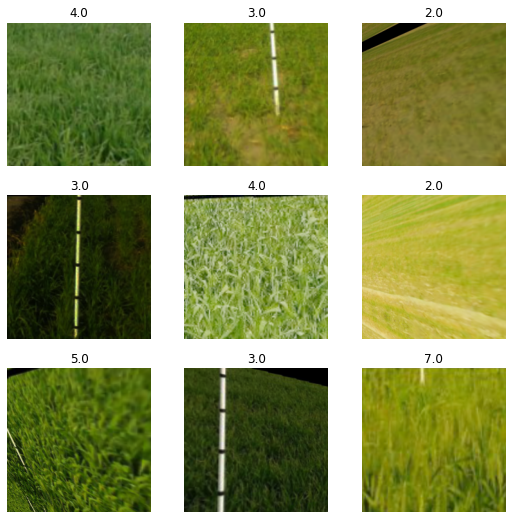

In [41]:
dls_dn201 = ImageDataLoaders.from_df(hq_data,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_dn201,
                               )

dls_dn201.show_batch()

In [42]:
learn_dn201 = cnn_learner(dls_dn201, densenet201, metrics=rmse, pretrained=True).to_fp16()
learn_dn201.fine_tune(70)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,_rmse,time
0,18.789404,12.198056,3.492572,00:26


epoch,train_loss,valid_loss,_rmse,time
0,13.008286,9.206324,3.034192,00:27
1,11.986719,8.295407,2.880175,00:27
2,11.012077,7.448755,2.729241,00:27
3,9.962185,5.699428,2.387347,00:26
4,8.844594,4.438992,2.106892,00:26
5,7.861897,4.110566,2.027453,00:26
6,6.597151,2.320128,1.523197,00:27
7,5.576180,1.862111,1.364592,00:27
8,4.889110,1.452585,1.205233,00:27
9,4.157746,0.845361,0.919435,00:27


SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=1.2022644114040304e-05)

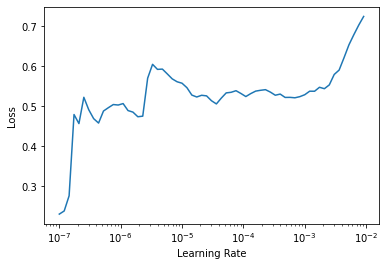

In [43]:
learn_dn201.unfreeze()
learn_dn201.lr_find()

In [44]:
learn_dn201.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.396373,0.262315,0.512167,00:26
1,0.431495,0.263796,0.513611,00:26
2,0.434889,0.263205,0.513035,00:26
3,0.410777,0.262091,0.511948,00:27
4,0.470864,0.260543,0.510434,00:26
5,0.441971,0.263734,0.513550,00:27
6,0.454956,0.266944,0.516666,00:26
7,0.454014,0.258915,0.508837,00:26
8,0.495678,0.264418,0.514216,00:26
9,0.477764,0.264037,0.513845,00:27


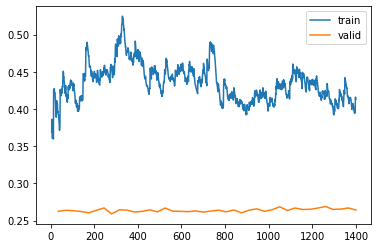

In [45]:
learn_dn201.recorder.plot_loss()

In [46]:
ss_dn201 = sub_df
tdl_dn201 = learn_dn201.dls.test_dl(ss_dn201)
pred_dn201 = learn_dn201.tta(dl=tdl_dn201)

In [47]:
ss_dn201['growth_stage'] = pred_dn201[0].numpy()
ss_dn201.head()

,UID,growth_stage
0,F3LbWkZq,4.332642
1,6P4wLVzI,3.701660
2,Tn6HIrdS,2.763062
3,EYM5R1TK,4.018433
4,fkcevlA0,5.314697


In [98]:
now = datetime.now()
file_name = 'models/DenseNet201_' + now.strftime('%d_%H%M') + '.pkl'
learn_dn201.export(file_name)

In [52]:
now = datetime.now()
file_name = 'sub/DenseNet201_' + now.strftime('%d_%H%M') + '.csv'
ss_dn201.to_csv(file_name, index=False)

# EfficientNet-B0

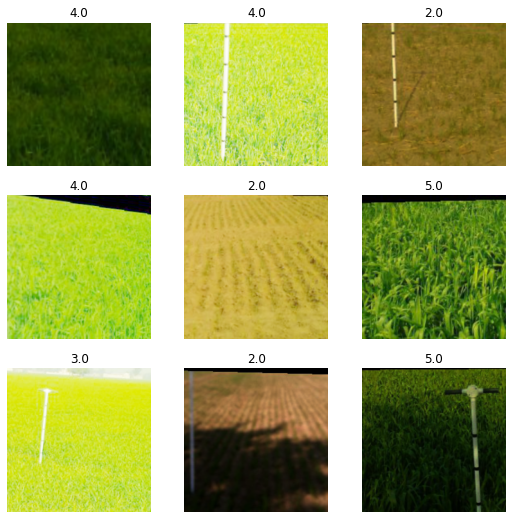

In [60]:
dls_en = ImageDataLoaders.from_df(hq_data,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock,
                               batch_tfms = tfms_en,
                               )

dls_en.show_batch()

In [66]:
arch = EfficientNet.from_pretrained('efficientnet-b0', advprop=True)
arch._fc = nn.Linear(1280, dls_en.c)

Loaded pretrained weights for efficientnet-b0


In [68]:
learn_en = Learner(dls_en, arch, metrics=rmse)
learn_en.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,4.686488,120.233406,10.965098,00:20


epoch,train_loss,valid_loss,_rmse,time
0,0.857581,7.586995,2.754450,00:19
1,0.714606,4.891273,2.211622,00:19
2,0.617140,1.270179,1.127022,00:19
3,0.558545,0.743490,0.862259,00:19
4,0.488563,0.535361,0.731683,00:19
5,0.458600,1.455762,1.206550,00:19
6,0.478510,1.298791,1.139645,00:19
7,0.471770,0.519835,0.720996,00:19
8,0.432623,0.402603,0.634510,00:19
9,0.430637,0.662293,0.813814,00:19


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

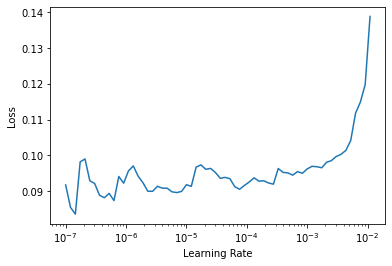

In [69]:
learn_en.unfreeze()
learn_en.lr_find()

In [70]:
learn_en.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.102786,0.242058,0.491994,00:19
1,0.100216,0.242361,0.492302,00:19
2,0.091433,0.238640,0.488508,00:19
3,0.091386,0.251775,0.501772,00:19
4,0.094102,0.249165,0.499164,00:19
5,0.092601,0.248498,0.498496,00:19
6,0.091919,0.245140,0.495116,00:19
7,0.094122,0.237283,0.487117,00:19
8,0.095293,0.259810,0.509716,00:19
9,0.096229,0.266677,0.516407,00:20


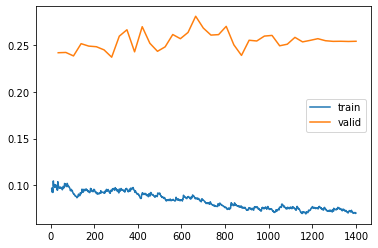

In [71]:
learn_en.recorder.plot_loss()

In [72]:
ss_en = sub_df
tdl_en = learn_en.dls.test_dl(ss_en)
pred_en = learn_en.tta(dl=tdl_en)

In [73]:
ss_en['growth_stage'] = pred_en[0].numpy()
ss_en.head()

,UID,growth_stage
0,F3LbWkZq,4.172538
1,6P4wLVzI,4.051332
2,Tn6HIrdS,2.900674
3,EYM5R1TK,4.073316
4,fkcevlA0,6.384021


In [99]:
now = datetime.now()
file_name = 'models/EfficientNet_' + now.strftime('%d_%H%M') + '.pkl'
learn_en.export(file_name)

In [75]:
now = datetime.now()
file_name = 'sub/EfficientNet_' + now.strftime('%d_%H%M') + '.csv'
ss_en.to_csv(file_name, index=False)

# Pseudo labeling

In [109]:
ss_vgg = lq_data
tdl_vgg = learn_vgg.dls.test_dl(ss_vgg)
pl_vgg = learn_vgg.tta(dl=tdl_vgg)

ss_vgg['growth_stage'] = pl_vgg[0].numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [112]:
now = datetime.now()
file_name = 'pl/vgg_' + now.strftime('%d_%H%M') + '.csv'
ss_vgg.to_csv(file_name, index=False)

ss_vgg.head()

,UID,growth_stage,label_quality
1,NVGUOzWu,6.029053,1
2,1IYVvHwA,4.476929,1
3,8OEdWwmU,3.257690,1
4,oc5iO04j,6.754639,1
5,A60rOyP9,6.977539,1


In [113]:
ss_res = lq_data
tdl_res = learn_res50.dls.test_dl(ss_res)
pl_res = learn_res50.tta(dl=tdl_res)

ss_res['growth_stage'] = pl_res[0].numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [114]:
now = datetime.now()
file_name = 'pl/res_' + now.strftime('%d_%H%M') + '.csv'
ss_res.to_csv(file_name, index=False)

ss_res.head()

,UID,growth_stage,label_quality
1,NVGUOzWu,6.284424,1
2,1IYVvHwA,3.813110,1
3,8OEdWwmU,2.994873,1
4,oc5iO04j,6.717285,1
5,A60rOyP9,6.843506,1


In [115]:
ss_dn = lq_data
tdl_dn = learn_dn201.dls.test_dl(ss_dn)
pl_dn = learn_dn201.tta(dl=tdl_dn)

ss_dn['growth_stage'] = pl_dn[0].numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [116]:
now = datetime.now()
file_name = 'pl/dn_' + now.strftime('%d_%H%M') + '.csv'
ss_dn.to_csv(file_name, index=False)

ss_dn.head()

,UID,growth_stage,label_quality
1,NVGUOzWu,6.356689,1
2,1IYVvHwA,3.159302,1
3,8OEdWwmU,3.224731,1
4,oc5iO04j,6.569336,1
5,A60rOyP9,6.892822,1


In [117]:
ss_en = lq_data
tdl_en = learn_en.dls.test_dl(ss_en)
pl_en = learn_en.tta(dl=tdl_en)

ss_en['growth_stage'] = pl_en[0].numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [118]:
now = datetime.now()
file_name = 'pl/en_' + now.strftime('%d_%H%M') + '.csv'
ss_en.to_csv(file_name, index=False)

ss_en.head()

,UID,growth_stage,label_quality
1,NVGUOzWu,6.904292,1
2,1IYVvHwA,6.491386,1
3,8OEdWwmU,3.028196,1
4,oc5iO04j,7.005983,1
5,A60rOyP9,7.002642,1


In [125]:
sub1 = pd.read_csv('pl/vgg_04_1231.csv', names=('UID', 'vgg', 'vgg_q'))
sub2 = pd.read_csv('pl/res_04_1235.csv', names=('UID', 'res', 'res_q'))
sub3 = pd.read_csv('pl/dn_04_1238.csv', names=('UID', 'dn', 'dn_q'))
sub4 = pd.read_csv('pl/en_04_1241.csv', names=('UID', 'en', 'en_q'))

In [131]:
pl_df = pd.merge(sub1, sub2, on='UID')
pl_df = pd.merge(pl_df, sub3, on='UID')
pl_df = pd.merge(pl_df, sub4, on='UID')

pl_df = pl_df.drop(index=[0])
pl_df = pl_df.drop(columns=['vgg_q', 'res_q', 'dn_q', 'en_q'])

name_list = ['vgg', 'res', 'dn', 'en']

for name in name_list:
    pl_df[name] = pl_df[name].astype(float)

pl_df.head()

,UID,vgg,res,dn,en
1,NVGUOzWu,6.029053,6.284424,6.356689,6.904292
2,1IYVvHwA,4.476929,3.813110,3.159302,6.491386
3,8OEdWwmU,3.257690,2.994873,3.224731,3.028196
4,oc5iO04j,6.754639,6.717285,6.569336,7.005983
5,A60rOyP9,6.977539,6.843506,6.892822,7.002642


In [133]:
pl_df['growth_stage'] = (
    pl_df.vgg * 0.25
    + pl_df.res * 0.25
    + pl_df.dn * 0.25
    + pl_df.en * 0.25
)

pl_df.head()

,UID,vgg,res,dn,en,growth_stage
1,NVGUOzWu,6.029053,6.284424,6.356689,6.904292,6.393614
2,1IYVvHwA,4.476929,3.813110,3.159302,6.491386,4.485182
3,8OEdWwmU,3.257690,2.994873,3.224731,3.028196,3.126373
4,oc5iO04j,6.754639,6.717285,6.569336,7.005983,6.761811
5,A60rOyP9,6.977539,6.843506,6.892822,7.002642,6.929127


In [134]:
pseudo = pl_df.drop(columns=['vgg', 'res', 'dn', 'en'])
hq_df = hq_data.drop(columns='label_quality')

In [141]:
pseudo_ds = pd.concat([pseudo, hq_df])
pseudo_ds.shape

(10695, 2)

In [138]:
main_df.shape, hq_data.shape, lq_data.shape

((10695, 3), (2856, 3), (7839, 3))

In [140]:
hq_df.shape, pseudo.shape

((2856, 2), (7839, 2))

In [142]:
pseudo_ds.to_csv('pseudo_label.csv', index=False)

# Ensembles

In [86]:
vgg = pd.read_csv('sub/VGG16_04_0908.csv', names=('UID', 'vgg'))
res = pd.read_csv('sub/ResNet50_04_0848.csv', names=('UID', 'res'))
dn = pd.read_csv('sub/DenseNet201_04_1007.csv', names=('UID', 'dn'))
en = pd.read_csv('sub/EfficientNet_04_1104.csv', names=('UID', 'en'))

In [87]:
model_list = [dn, en]

merged = pd.merge(vgg, res, on='UID')


for model in model_list:
    merged = pd.merge(merged, model, on='UID')

merged = merged.drop(index=[0])
merged = merged.reset_index()
merged.head()

,index,UID,vgg,res,dn,en
0,1,F3LbWkZq,4.399414,3.6340332,4.3326416,4.172538
1,2,6P4wLVzI,3.704834,3.7696533,3.7016602,4.0513315
2,3,Tn6HIrdS,2.7875977,2.6870117,2.7630615,2.9006736
3,4,EYM5R1TK,4.1015625,4.0963135,4.0184326,4.0733156
4,5,fkcevlA0,5.3742676,5.4121094,5.3146973,6.3840213


In [88]:
name_list = ['vgg', 'res', 'dn', 'en']

for name in name_list:
    merged[name] = merged[name].astype(float)

In [83]:
UID = merged['UID']
merged = merged.drop(columns=['index', 'UID'])

In [89]:
merged['pred'] = (
    merged.vgg * 0.25
    + merged.res * 0.25
    + merged.dn * 0.25
    + merged.en * 0.25
)

merged.head()

,index,UID,vgg,res,dn,en,pred
0,1,F3LbWkZq,4.399414,3.634033,4.332642,4.172538,4.134657
1,2,6P4wLVzI,3.704834,3.769653,3.701660,4.051331,3.806870
2,3,Tn6HIrdS,2.787598,2.687012,2.763062,2.900674,2.784586
3,4,EYM5R1TK,4.101562,4.096313,4.018433,4.073316,4.072406
4,5,fkcevlA0,5.374268,5.412109,5.314697,6.384021,5.621274


In [92]:
now = datetime.now()
counter += 1
file_name = 'sub/ensemble_' + now.strftime('%d_%H%M') + '_ver' + str(counter) + '.csv'

merged[['UID', 'pred']].to_csv(file_name, index=False)

In [90]:
counter = 0